In [1]:
from schnetpack import AtomsData, AtomsLoader
from ase.visualize import view
import torch 
import numpy as np
from matplotlib import pyplot as plt
import h5py
from qml.representations import *
import sys
import pandas as pd
import time
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from VAE import base_VAE

2021-11-08 16:09:21.493516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-08 16:09:21.493745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
plt.rcParams["figure.figsize"] = (20, 20)

In [3]:
df=pd.read_json('./dataframe41537.json')

In [5]:
from separate_models import prop_ls_lin, prop_ls_NN
prop_list=list(df.columns[df.columns != 'BoB'])[8:53]
latent_size=30#len(prop_list) #here the latent size is set to the lenght of the property list but this is not necessary. It would be nice for invertibility of linear mappings
input_dim=len(df['BoB'][0])

config_num=1
PATH='./VAE_separate/onlyreco_trained_models/config_num_{}'.format(config_num)
#torch.save(last_model.state_dict(), PATH)
model = base_VAE(input_dim=input_dim, latent_size=latent_size)
model.load_state_dict(torch.load(PATH))
PATH='./VAE_separate/prop_ls_lin_trained_models/config_num_{}'.format(config_num)
#torch.save(last_model.state_dict(), PATH)
model_0 = prop_ls_NN(latent_size=latent_size,prop_size=len(prop_list))
model_0.load_state_dict(torch.load(PATH))

RuntimeError: Error(s) in loading state_dict for prop_ls_NN:
	Missing key(s) in state_dict: "model.0.weight", "model.0.bias", "model.2.weight", "model.2.bias", "model.4.weight", "model.4.bias". 
	Unexpected key(s) in state_dict: "model_mu.0.weight", "model_mu.0.bias", "model_mu.2.weight", "model_mu.2.bias", "model_mu.4.weight", "model_mu.4.bias", "model_logvar.0.weight", "model_logvar.0.bias", "model_logvar.2.weight", "model_logvar.2.bias", "model_logvar.4.weight", "model_logvar.4.bias". 

In [32]:
def perc_error(a,b):
    a=torch.Tensor(a).abs()
    b=torch.Tensor(b)
    numer=torch.sum((a-b).abs())
    denom=torch.sum(b.abs())
    return 100*torch.mean(numer/denom)

def tmp(x):
    model_0.eval()
    model.eval()
    with torch.no_grad():
        u_reco,logvar=model_0(x)
        x_reco,logvar2=model.decode(u_reco)
    return list(x_reco)

#tmp(torch.Tensor(df[prop_list].iloc[0]))[0].tolist()
#df['reconstructed']=df[prop_list].apply(lambda x: tmp(torch.Tensor(x))[0].tolist(),axis=1)
#df

In [33]:
df['error_reco']=df[['reconstructed','BoB']].apply(lambda x: perc_error(*x),axis=1)
df['error_reco'].apply(lambda x: x.item())

5.35655108698269

(0.0, 10.0)

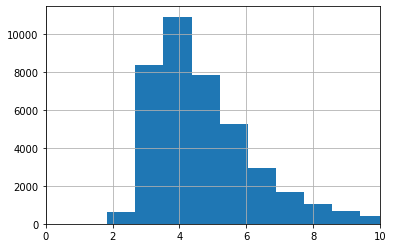

In [40]:
df['error_reco'].hist(bins=1000)
plt.xlim([0,10])

(array([196.,  53.,  47.,  48.,  77.,  23.,  22.,  58.,  56.,  81.,   1.,
          5.,   4.,   4.,  21.,   2.,  17.,  23.,  23.,   2.,   4.,   5.,
          5.,   1.,   7.,   2.,   0.,   0.,   5.,   4.,   0.,  26.,   4.,
          1.,   1.,  32.,  17.,  27.,   8.,  42.,   6.,   7.,   6.,   4.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   4.,   1.,
          4.,   7.,   0.,   0.,   9.,   6.,   1.,  23.,  23.,  29.,  46.,
         10.,   2.,   2.,  10.,   7.,   3.,   9.,   0.,  14.,   9.,   4.,
         15.,  11.,  32.,   0.,   2.,   5.,  14.,  21.,   1.,   2.,  11.,
         36.,  11.,  12.,   1.,   5.,  22.,  17.,  38.,   9.,  40., 114.,
        177.]),
 array([    0.  ,   415.36,   830.72,  1246.08,  1661.44,  2076.8 ,
         2492.16,  2907.52,  3322.88,  3738.24,  4153.6 ,  4568.96,
         4984.32,  5399.68,  5815.04,  6230.4 ,  6645.76,  7061.12,
         7476.48,  7891.84,  8307.2 ,  8722.56,  9137.92,  9553.28,
         9968.64, 10384.  , 10799.36, 11214.72

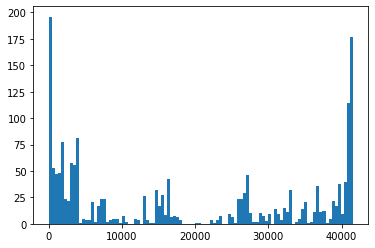

In [45]:
tempo=df[df['error_reco']>10]
indexes=tempo.index
plt.hist(indexes,bins=100)

3.4241410727206687

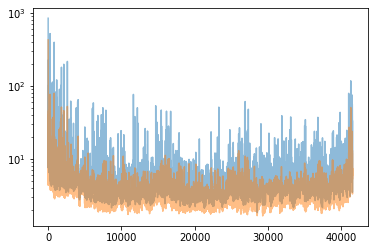

In [55]:
df['error_reco'].plot(alpha=0.5)
df['reco_error'].plot(alpha=0.5)

plt.yscale('log')
df['reco_error'].mean()

In [52]:
df['reco_error']=df['reco_error'].apply(lambda x: x.item())

In [49]:
#from Utils import perc_error
def perc_error(a,b):
    numer=torch.sum((a-b).abs())
    denom=torch.sum(b.abs())
    #print(numer.size())
    return 100*torch.mean(numer/denom)

def elem_perc_error(a,b):
    numer=((a-b).abs()).numpy()
    denom=(b.abs()+torch.ones_like(b)).numpy()
    #print(denom.size())
    return list(np.divide(numer,denom))
    
def tmp(x):
    model.eval()
    with torch.no_grad():
        x_reco,logvar,mu,logvar,z=model(x)
    return perc_error(x_reco.abs(),x)

df['reco_error']=df['BoB'].apply(lambda x: tmp(torch.Tensor(x)))
#df

In [ ]:
def tmp3(x):
    model.eval()
    with torch.no_grad():
        x_reco,logvar,mu,logvar,z=model(x)
    return list(elem_perc_error(x_reco.abs(),x))
df['reco_error_vec']=df['BoB'].apply(lambda x: tmp3(torch.Tensor(x)))

In [ ]:
d=df['reco_error_vec'].values
np.shape(list(d))

In [ ]:
#d=np.array(list(d))[:,0,:]
plt.contourf(X,Y,sigmoid(d))

In [ ]:
ax=df['reco_error'].apply(lambda x: x.item()).hist(bins=1000)
ax.set_xlim([0,30])

In [ ]:
df['reco_error'].apply(lambda x: x.item()).plot(logy=True) 

In [ ]:
df2=df[df['reco_error'].apply(lambda x: x.item())>=30]
indexes=df2.index
df2

In [ ]:
df3=df[df['reco_error'].apply(lambda x: x.item())<=2.5]
indexes=df3.index
plt.hist(indexes,bins=100)

In [ ]:
tmp=df['BoB'].apply(lambda x: np.count_nonzero(x))
tmp.plot(alpha=0.5)
plt.hist(indexes,bins=100)

In [ ]:
unique_data

In [ ]:
def tmp2(x):
    x=np.array(x)
    c=x!=0
    return list(c.astype(int))
nonzero_bonds=df['BoB'].apply(lambda x: tmp2(x))
d=nonzero_bonds.values

In [ ]:
hist=np.sum(list(d),axis=0)

In [ ]:
plt.plot(hist)
plt.yscale('log')

In [ ]:
isto=df['BoB'].values
isto=list(isto)
plt.imshow(isto,interpolation='none')

In [ ]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook  
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 528, 1)
Y = np.arange(0, 41537, 1)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, np.log(1+np.array(isto)), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


In [ ]:
plt.rcParams["figure.figsize"] = (10, 10)

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [ ]:
plt.contourf(X,Y,sigmoid(np.array(isto)))